In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import patsy
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import math

import warnings

warnings.filterwarnings("ignore")
sns.set()
sns.set_context('talk')

In [2]:
def change(num):
    if num <= 0:
        return 1
    else:
        return np.log(num)

def dummy_var(col, df):
    temp_df = df
    temp = pd.get_dummies(temp_df[col], prefix = col, drop_first = True) #one hot encoding drop the default view = 0
    temp_df = temp_df.join(temp)
    temp_df.drop([col], axis = 1, inplace = True)
    return temp_df #only the dummy variables

def rmse(y_true, y_pred): #having custom loss function
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [3]:
data = pd.read_csv('Seattle_Houses.csv')
data.drop(['id', 'date', 'zipcode'], inplace = True, axis = 1)

In [4]:
data.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

There are a total of 19 variables and 21000+ observations included in this data set. However, there are many variables that seem to be variations of each other. For instance, view and waterfront seem to be very similar. Additionally, sqft_living15 and sqft_lot15 seem to be derived from the sqft_living and swft_lot variables. 

Just looking at the varaibles included in the data set, we hypothesize that the number of bedrooms and bathrooms, sqft_living and sqft_lot will be the most significant when predicting the housing prices. We believe these four variables are the most important because these are the most important features of a house: how big it is and how many people are able to live in the residence. Additionally, the view would be significant because from our experience, houses with a nice view tend to sell for higher prices

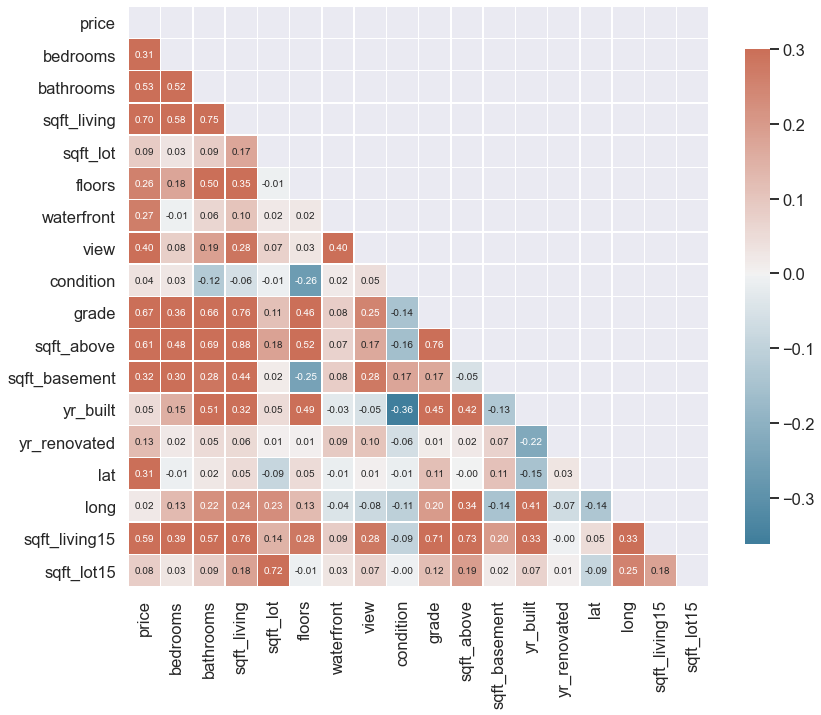

In [5]:
fig, ax = plt.subplots(figsize = (13, 13))
cmap = sns.diverging_palette(230, 20, as_cmap = True)
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0, square = True, 
            linewidths = .5, cbar_kws = {"shrink": .7}, annot = True, fmt = '.2f', ax = ax, annot_kws = {"size": 10})

plt.savefig('corr.png', bbox_inches='tight')
plt.show()

From the correlation heatmap above, we see the top 5 features that are most correlated with price are sqft_living (0.7), grade (0.67), sqft_above(0.61), sqft_living15 (0.59), and bathrooms (0.53). 

We see sqft_living is highly correlated with sqft_living15 (0.76), sqft_above (0.88), grade (0.76), and bathrooms (0.75). We chose the threshold of multicollinearity to be 0.7, i.e if two predictors were correlated at least 0.7, then we would only choose one of the predictors. Because these five variables are highly correlated with each other (greater than our chosen threshold), if we include them all in the regression model, we will be violating the assumption of independence among the predictor variables. Hence, we choose to only include sqft_living because it is the most correlated with price among sqft_living, sqft_living15, sqft_above, grade, and bathrooms. Consequently, we need to add more predictor variables. We will be utilizing sqft_living, sqft_basement, bedrooms, lat, and view in our multiple linear regression model. 

To visualize the distributions of the predictors, we plot the sqft_living, sqft_basement, bedrooms, lat, and view predictor vairables and price, the outcome variable. 

In [6]:
data['price_log'] = data['price'].apply(change)

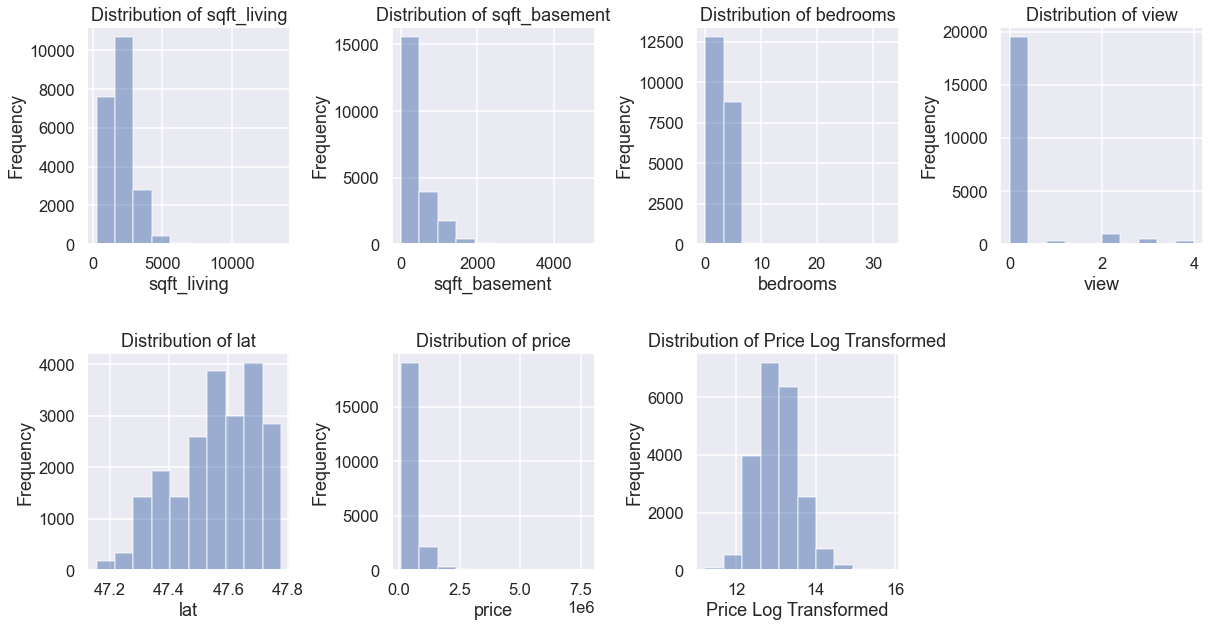

In [7]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

data['sqft_living'].plot(kind = 'hist', ax = ax[0][0], alpha = 0.5)
ax[0][0].set_title('Distribution of sqft_living')
ax[0][0].set_ylabel('Frequency')
ax[0][0].set_xlabel('sqft_living')

data['sqft_basement'].plot(kind = 'hist', ax = ax[0][1], alpha = 0.5)
ax[0][1].set_title('Distribution of sqft_basement')
ax[0][1].set_ylabel('Frequency')
ax[0][1].set_xlabel('sqft_basement')

data['bedrooms'].plot(kind = 'hist', ax = ax[0][2], alpha = 0.5)
ax[0][2].set_title('Distribution of bedrooms')
ax[0][2].set_ylabel('Frequency')
ax[0][2].set_xlabel('bedrooms')

data['view'].plot(kind = 'hist', ax = ax[0][3], alpha = 0.5)
ax[0][3].set_title('Distribution of view')
ax[0][3].set_ylabel('Frequency')
ax[0][3].set_xlabel('view')

data['lat'].plot(kind = 'hist', ax = ax[1][0], alpha = 0.5)
ax[1][0].set_title('Distribution of lat')
ax[1][0].set_ylabel('Frequency')
ax[1][0].set_xlabel('lat')

data['price'].plot(kind = 'hist', ax = ax[1][1], alpha = 0.5)
ax[1][1].set_title('Distribution of price')
ax[1][1].set_ylabel('Frequency')
ax[1][1].set_xlabel('price')

data['price_log'].plot(kind = 'hist', ax = ax[1][2], alpha = 0.5)
ax[1][2].set_title('Distribution of Price Log Transformed')
ax[1][2].set_xlabel('Price Log Transformed')
ax[1][2].set_ylabel('Frequency')

fig.delaxes(ax[1][3])

plt.savefig('distributions.png', bbox_inches='tight')
plt.show()

Above, we see the distributions of the 5 predictors plus the outcome variable. The distributions of sqft_living seems to be somewhat normal with it being skewed a little bit to the right. Additionally, for the variable of view, we see almost all of the observations in the data have a view of 0. The distribution of price, the outcome variable is extremely skewed to the right. Hence we log transform the data so that the distribution is more normal. 

Above, we see the distribution of the housing prices after log transformming the data. We see that the distribution is more normal now. 

In [8]:
temp_df = data
temp = pd.get_dummies(temp_df['view'], prefix = 'View', drop_first = True) #one hot encoding drop the default view = 0
temp_df = temp_df.join(temp)
temp_df.drop(['view'], axis = 1, inplace = True)

In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
kf = KFold(n_splits = 5, shuffle = True)
first = ['First Model']
second = ['Second Model']
first_temp = []
second_temp = []
for train, test in kf.split(temp_df):
    first_train_x = temp_df.iloc[train][['sqft_living', 'bedrooms'] + list(temp.columns)]
    first_train_y = temp_df.iloc[train][['price_log']]
    first_test_x = temp_df.iloc[test][['sqft_living', 'bedrooms'] + list(temp.columns)]
    first_test_y = temp_df.iloc[test][['price_log']]
    
    second_train_x = temp_df.iloc[train][['sqft_living', 'sqft_basement', 'bedrooms', 'lat'] + list(temp.columns)]
    second_train_y = temp_df.iloc[train][['price_log']]
    second_test_x = temp_df.iloc[test][['sqft_living', 'sqft_basement', 'bedrooms', 'lat'] + list(temp.columns)]
    second_test_y = temp_df.iloc[test][['price_log']]
    
    mlr1 = LinearRegression().fit(first_train_x, first_train_y)
    first_y_pred = mlr1.predict(first_test_x)
    first.append(str(round(mean_squared_error(first_test_y, first_y_pred, squared = False), 3)) + '(' + str(round(r2_score(first_test_y, first_y_pred), 3)) + ')')
    first_temp.append(round(mean_squared_error(first_test_y, first_y_pred, squared = False), 3))
    
    mlr2 = LinearRegression().fit(second_train_x, second_train_y)
    second_y_pred = mlr2.predict(second_test_x)
    second.append(str(round(mean_squared_error(second_test_y, second_y_pred, squared = False), 3)) + '(' + str(round(r2_score(second_test_y, second_y_pred), 3)) + ')')
    second_temp.append(round(mean_squared_error(second_test_y, second_y_pred, squared = False), 3))

    
#first = [first[0]] + [round(i, 5) for i in first[1:]]
#second = [second[0]] + [round(i, 5) for i in second[1:]]

In [10]:
kf_df = pd.DataFrame([first, second], columns = ['Model', '1st Iteration', '2nd Iteration', \
                                                    '3rd Iteration', '4th Iteration', '5th Iteration'])
kf_df.set_index(['Model'], inplace = True)
kf_df['Mean RMSE'] = [np.mean(first_temp), np.mean(second_temp)]
kf_df.to_csv('kf_df.csv', index = True)
kf_df

,1st Iteration,2nd Iteration,3rd Iteration,4th Iteration,5th Iteration,Mean RMSE
Model,,,,,,
First Model,0.377(0.483),0.367(0.537),0.363(0.517),0.364(0.519),0.37(0.5),0.3682
Second Model,0.306(0.66),0.294(0.702),0.289(0.694),0.292(0.689),0.299(0.674),0.2960


In [11]:
train, test = train_test_split(temp_df, test_size = 0.2)

In [12]:
x_train = train[['sqft_living', 'sqft_basement', 'bedrooms', 'lat'] + list(temp.columns)]
y_train = train[['price_log']]

x_test = test[['sqft_living', 'sqft_basement', 'bedrooms', 'lat'] + list(temp.columns)]
y_test = test[['price_log']]

In [13]:
outcome, predictors = patsy.dmatrices('price_log ~ View_1 + View_2 + View_3 + View_4 + sqft_living + sqft_basement + bedrooms + lat', data = train)
mod = sm.OLS(outcome, predictors).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     4672.
Date:                Thu, 22 Jul 2021   Prob (F-statistic):               0.00
Time:                        21:21:26   Log-Likelihood:                -3474.1
No. Observations:               17290   AIC:                             6966.
Df Residuals:                   17281   BIC:                             7036.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -63.7944      0.780    -81.762

In [14]:
inter = ['Intercept', round(mod.params[0], 3), round(mod.bse[0], 3), 
         round(mod.tvalues[0], 3), round(mod.pvalues[0], 5), str(np.round(mod.conf_int(alpha=0.05)[0], 3))]
view1 = ['View = 1', round(mod.params[1], 3), round(mod.bse[1], 3), 
         round(mod.tvalues[1], 3), round(mod.pvalues[1], 5), str(np.round(mod.conf_int(alpha=0.05)[1], 3))]
view2 = ['View = 2', round(mod.params[2], 3), round(mod.bse[2], 3), 
         round(mod.tvalues[2], 3), round(mod.pvalues[2], 5), str(np.round(mod.conf_int(alpha=0.05)[2], 3))]
view3 = ['View = 3', round(mod.params[3], 3), round(mod.bse[3], 3), 
         round(mod.tvalues[3], 3), round(mod.pvalues[3], 5), str(np.round(mod.conf_int(alpha=0.05)[3], 3))]
view4 = ['View = 4', round(mod.params[4], 3), round(mod.bse[4], 3), 
         round(mod.tvalues[4], 3), round(mod.pvalues[4], 5), str(np.round(mod.conf_int(alpha=0.05)[4], 3))]
living = ['sqft_living', "{:.2e}".format(mod.params[5]), "{:.2e}".format(mod.bse[5]), 
         round(mod.tvalues[5], 3), round(mod.pvalues[5], 5), str(np.round(mod.conf_int(alpha=0.05)[5], 3))]
basement = ['sqft_basement', "{:.2e}".format(mod.params[6]), "{:.2e}".format(mod.bse[6]), 
         round(mod.tvalues[6], 3), round(mod.pvalues[6], 5), str(np.round(mod.conf_int(alpha=0.05)[7], 3))]
bed = ['bedrooms', round(mod.params[7], 3), round(mod.bse[7], 3), 
         round(mod.tvalues[7], 3), round(mod.pvalues[7], 5), str(np.round(mod.conf_int(alpha=0.05)[8], 3))]
lat = ['lat', round(mod.params[8], 3), round(mod.bse[8], 3), 
         round(mod.tvalues[8], 3), round(mod.pvalues[8], 5), str(np.round(mod.conf_int(alpha=0.05)[8], 3))]

df = pd.DataFrame([inter, view1, view2, view3, view4, living, basement, bed, lat], 
                  columns = ['Parameters', 'Coefficients', 'Standard Error', \
                             'T-Statistics', 'P-Values', '95% Confidence Interval'])

df.set_index('Parameters', inplace = True)
print('Adjusted R-Squared: ' + str(round(mod.rsquared, 5)))
df.to_csv('coef.csv', index = True)
df

Adjusted R-Squared: 0.68383


,Coefficients,Standard Error,T-Statistics,P-Values,95% Confidence Interval
Parameters,,,,,
Intercept,-63.794,0.78,-81.762,0.0,[-65.324 -62.265]
View = 1,0.244,0.019,13.174,0.0,[0.208 0.281]
View = 2,0.215,0.011,19.297,0.0,[0.194 0.237]
View = 3,0.312,0.015,20.543,0.0,[0.282 0.342]
View = 4,0.534,0.019,27.793,0.0,[0.496 0.571]
sqft_living,3.84e-04,3.28e-06,117.292,0.0,[0. 0.]
sqft_basement,-7.04e-05,5.82e-06,-12.098,0.0,[-0.026 -0.014]
bedrooms,-0.02,0.003,-6.785,0.0,[1.568 1.632]
lat,1.6,0.016,97.567,0.0,[1.568 1.632]


From the model we had fitted above, we see all of the predictor variables were significant. Each predictor variable had a p-value very close to 0 (shown as 0 due to rounding), less than the threshold of $\alpha = 0.05$. Additionally, looking at the T-Statistic values, we see the predictor of sqft_living is the most significant with a value of $113.061$. 

In our model, because we had multiple predictors, we look at the adjusted R-squared for information regarding how much of the data's variance is actually explained by our model. We see the adjusted r-squared value is $0.6247 = 62.47\%$. This leads us to conclude that our model only explains around half of the data's variance and may not do a good job in predicting house prices in Seattle. 

Proceeding with the prediction, we utilize the Linear Regression package from sklearn. As for training and testing, we use an 80/20 split, 80% of the data (around 16800) is used for training while 20% of the data (around 4200) is used for testing. 

In [15]:
mlr = LinearRegression().fit(x_train, y_train)
y_pred = mlr.predict(x_test)

mean_squared_error(y_test, y_pred, squared = False)

0.2958626341680209

After predicting the log transformation of the price, we obtain a root mean squared error or $0.2963$

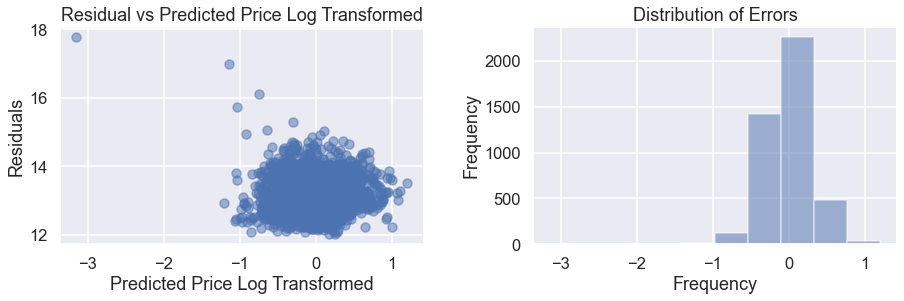

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
plt.subplots_adjust(wspace = 0.3)

residuals = np.array(y_test['price_log']) - y_pred.flatten()
ax[0].scatter(residuals, y_pred, alpha = 0.5)
ax[0].set_title('Residual vs Predicted Price Log Transformed')
ax[0].set_xlabel('Predicted Price Log Transformed')
ax[0].set_ylabel('Residuals')

pd.Series(residuals).plot(kind = 'hist', alpha = 0.5, ax = ax[1])
ax[1].set_title('Distribution of Errors')
ax[1].set_xlabel('Errors')
ax[1].set_xlabel('Frequency')

plt.savefig('errors.png', bbox_inches='tight')
plt.show()

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras import backend as K
from sklearn import preprocessing
from sklearn.preprocessing import scale

In [18]:
for i in ['view', 'grade', 'condition']:
    data = dummy_var(i, data)

In [26]:
temp_df = data
temp = [i for i in list(temp_df.columns) if 'view' in i]

kf = KFold(n_splits = 5, shuffle = True)
first = ['First Model']
second = ['Second Model']
first_rmse = []
second_rmse = []
third_rmse = []
first_r = []
second_r = []
third_r = []
for train, test in kf.split(temp_df):
    #first nn with all predictors
    first_train_x = temp_df.iloc[train].drop(['price', 'sqft_lot15', 'sqft_living15', 'price_log'], axis = 1)
    first_train_y = temp_df.iloc[train][['price_log']]
    first_test_x = temp_df.iloc[test].drop(['price', 'sqft_lot15', 'sqft_living15', 'price_log'], axis = 1)
    first_test_y = temp_df.iloc[test][['price_log']]
    
    #second nn with linear regression predictors
    second_train_x = temp_df.iloc[train][['sqft_living', 'sqft_basement', 'bedrooms', 'lat'] + temp]
    second_train_y = temp_df.iloc[train][['price_log']]
    second_test_x = temp_df.iloc[test][['sqft_living', 'sqft_basement', 'bedrooms', 'lat'] + temp]
    second_test_y = temp_df.iloc[test][['price_log']]
    
    #third lasso 
    temp_3 = pd.DataFrame(scale(temp_df), columns = temp_df.columns) #standardize data
    third_train_x = temp_3.iloc[train].drop(['price', 'sqft_lot15', 'sqft_living15', 'price_log'], axis = 1)
    third_train_y = temp_3.iloc[train][['price_log']]
    third_test_x = temp_3.iloc[test].drop(['price', 'sqft_lot15', 'sqft_living15', 'price_log'], axis = 1)
    third_test_y = temp_3.iloc[test][['price_log']]
    
    #first fitting
    model = Sequential()
    model.add(Dense(128, input_dim = first_train_x.shape[1], activation = 'relu'))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss = rmse, optimizer = 'rmsprop', metrics = ['RootMeanSquaredError'])

    model.fit(first_train_x, first_train_y, batch_size = 32, epochs = 30, validation_split = 0.2, verbose = 0)
    prediction = model.predict(first_test_x)
    first_rmse.append(round(mean_squared_error(first_test_y, prediction, squared = False), 3))
    first_r.append(round(r2_score(first_test_y, prediction), 3))
    
    #second fitting
    model = Sequential()
    model.add(Dense(128, input_dim = second_train_x.shape[1], activation = 'relu'))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss = rmse, optimizer = 'rmsprop', metrics = ['RootMeanSquaredError'])

    model.fit(second_train_x, second_train_y, batch_size = 32, epochs = 15, validation_split = 0.2, verbose = 0)
    prediction = model.predict(second_test_x)
    second_rmse.append(round(mean_squared_error(second_test_y, prediction, squared = False), 3))
    second_r.append(round(r2_score(second_test_y, prediction), 3))
    
    #third fitting
    df = data.drop(['price', 'sqft_lot15', 'sqft_living15', 'price_log'], axis = 1)
    df = pd.DataFrame(scale(df), columns = df.columns) #standardized
    model_la = Lasso(alpha = 1).fit(third_train_x, third_train_y)
    prediction_la = model_la.predict(third_test_x)
    third_rmse.append(round(mean_squared_error(third_test_y, prediction_la, squared = False), 3))
    third_r.append(round(r2_score(third_test_y, prediction_la), 3))
    
first_rmse.append(np.mean(first_rmse))
second_rmse.append(np.mean(second_rmse))
third_rmse.append(np.mean(third_rmse))

In [28]:
first = []
second = []
third = []
for i in range(5):
    first.append(str(first_rmse[i]) + ' (' + str(first_r[i]) + ')')
    second.append(str(second_rmse[i]) + ' (' + str(second_r[i]) + ')')
    third.append(str(third_rmse[i]) + ' (' + str(third_r[i]) + ')')
    
first.append(first_rmse[-1])
second.append(second_rmse[-1])
third.append(third_rmse[-1])

kf_df2 = pd.DataFrame([first_rmse, second_rmse, third_rmse], columns = ['1st Iteration', '2nd Iteration', \
                                                    '3rd Iteration', '4th Iteration', '5th Iteration', 'Mean RMSE'])

kf_df2['Model'] = ['First Model', 'Second Model', 'Third Model']
kf_df2.set_index(['Model'], inplace = True)
kf_df2.to_csv('kf_df.csv', index = True)
kf_df2

,1st Iteration,2nd Iteration,3rd Iteration,4th Iteration,5th Iteration,Mean RMSE
Model,,,,,,
First Model,0.773,0.843,1.050,0.796,0.713,0.8350
Second Model,0.621,0.567,0.524,0.626,0.379,0.5434
Third Model,1.012,0.999,0.993,0.995,1.001,1.0000


In [44]:
x = data

temp = [i for i in list(x.columns) if 'view' in i]
train, test = train_test_split(x, test_size = 0.2)

train_x = train[['sqft_living', 'sqft_basement', 'bedrooms', 'lat'] + temp]
train_y = train['price_log']

test_x = test[['sqft_living', 'sqft_basement', 'bedrooms', 'lat'] + temp]
test_y = test['price_log']

In [45]:
model = Sequential()
model.add(Dense(128, input_dim = train_x.shape[1], activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))
model.compile(loss = rmse, optimizer = 'rmsprop', metrics = ['RootMeanSquaredError'])

model.fit(train_x, train_y, batch_size = 32, epochs = 15, validation_split = 0.2, verbose = 0)
prediction = model.predict(test_x)
print('RMSE:', round(mean_squared_error(test_y, prediction, squared = False), 3))
print('R-squared', round(r2_score(test_y, prediction), 3))

RMSE: 0.643
R-squared -0.535


In [ ]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import scale

In [ ]:
train_x = train.drop(['price', 'sqft_lot15', 'sqft_living15', 'price_log'], axis = 1)
train_y = train['price_log']

test_x = test.drop(['price', 'sqft_lot15', 'sqft_living15', 'price_log'], axis = 1)
test_y = test['price_log']

In [ ]:
df = data.drop(['price', 'sqft_lot15', 'sqft_living15', 'price_log'], axis = 1)
df = pd.DataFrame(scale(df), columns = df.columns) #standardized
model_la = Lasso(alpha = 1).fit(train_x, train_y)
prediction_la = model_la.predict(test_x)
mean_squared_error(test_y, prediction_la, squared = False)